In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

# Sprint 1

Loading train, test and gender csv files

In [3]:
train = pd.DataFrame(pd.read_csv("Titanic_train.csv"))
test = pd.DataFrame(pd.read_csv("Titanic_est.csv"))
gender = pd.DataFrame(pd.read_csv("gender_submission.csv"))

In [4]:
train.shape

(891, 12)

In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
gender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [7]:
full = train.append( test , ignore_index = True )
titanic = full[ :891 ]

del train , test

print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)

('Datasets:', 'full:', (1309, 12), 'titanic:', (891, 12))


In [8]:
full.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [9]:
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


### Variable Description

Survived: Survived (1) or died (0)

Pclass: Passenger's class

Name: Passenger's name

Sex: Passenger's sex

Age: Passenger's age

SibSp: Number of siblings/spouses aboard

Parch: Number of parents/children aboard

Ticket: Ticket number

Fare: Fare

Cabin: Cabin

Embarked: Port of embarkation

In [10]:
missing = titanic.isnull().sum(axis=0).reset_index()
missing.columns = ['column_name', 'missing_count']
missing['filling_factor'] = (titanic.shape[0]- missing['missing_count']) / titanic.shape[0] * 100
missing.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,Cabin,687,22.895623
1,Age,177,80.134680
2,Embarked,2,99.775533
3,Fare,0,100.000000
4,Name,0,100.000000
5,Parch,0,100.000000
6,PassengerId,0,100.000000
7,Pclass,0,100.000000
8,Sex,0,100.000000
9,SibSp,0,100.000000


In [11]:
titanic.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


In [12]:
def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

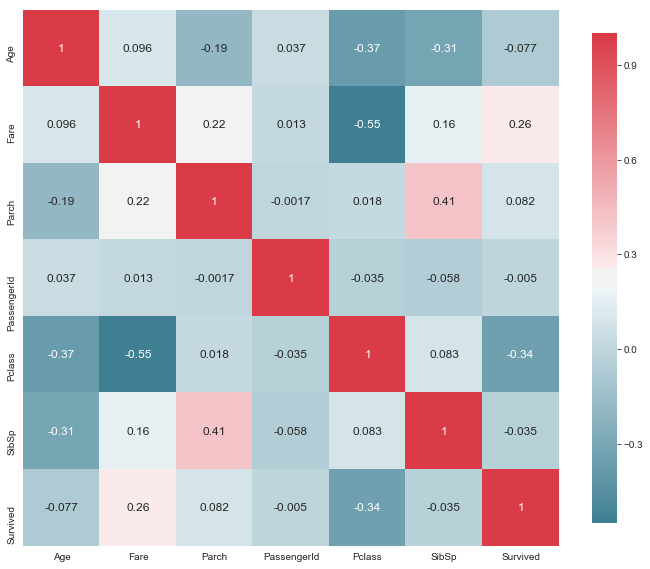

In [13]:
plot_correlation_map(titanic)

In [14]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

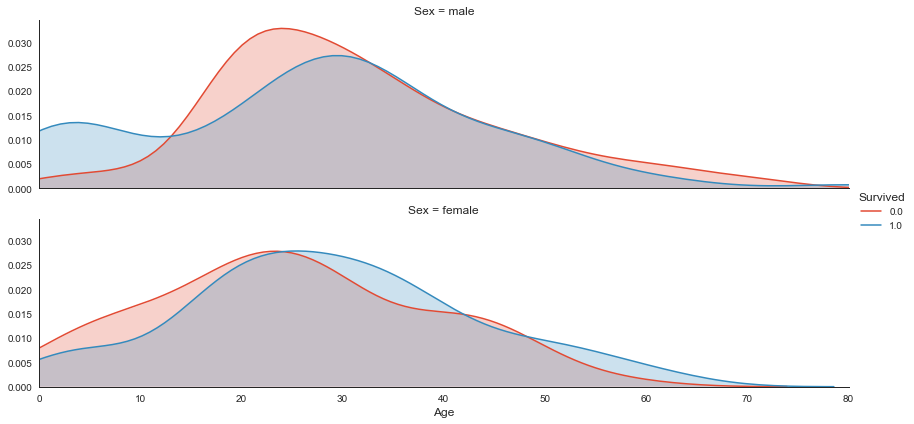

In [15]:
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex' )

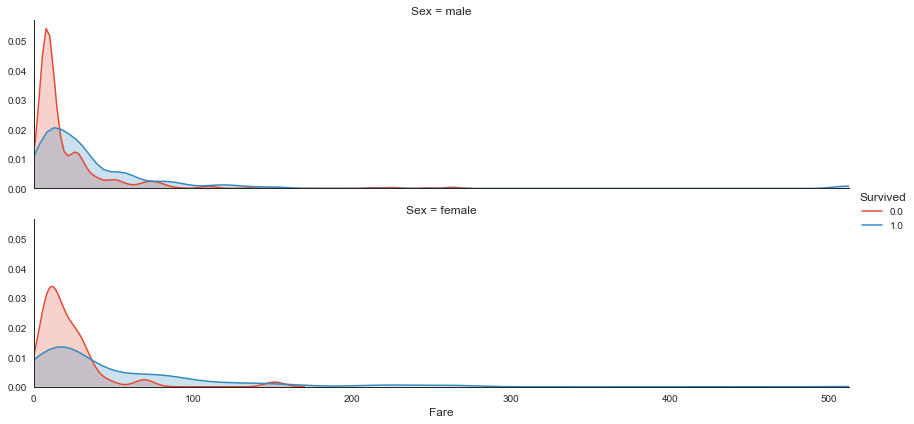

In [16]:
# Plot distributions of Fare of passangers who survived or did not survive
plot_distribution( titanic , var = 'Fare' , target = 'Survived' , row = 'Sex' )

In [17]:
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

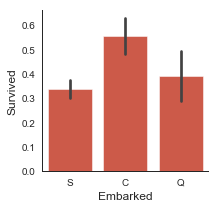

In [18]:
import warnings
warnings.filterwarnings('ignore')

# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )

# C = Cherbourg
# Q = Queenstown
# S = Southampton

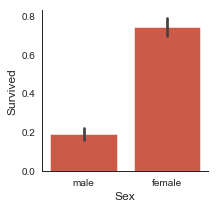

In [19]:
plot_categories( titanic , cat = 'Sex' , target = 'Survived' )

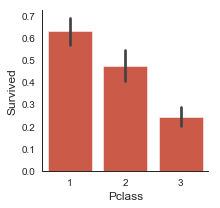

In [20]:
plot_categories( titanic , cat = 'Pclass' , target = 'Survived' )

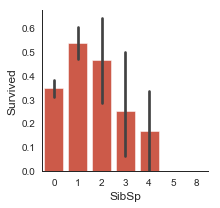

In [21]:
plot_categories( titanic , cat = 'SibSp' , target = 'Survived' )

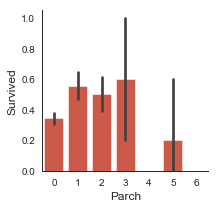

In [22]:
plot_categories( titanic , cat = 'Parch' , target = 'Survived' )

### Data Preparation

Categorical variables need to be transformed to numeric variables

In [23]:
# Transform Sex into binary values 0 and 1
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

In [24]:
# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [25]:
# Create a new variable for every unique value of Embarked
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


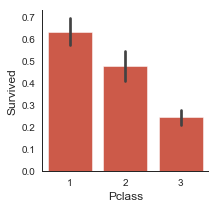

In [72]:
plot_categories( full , cat = 'Pclass' , target = 'Survived' )

In [26]:
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


### Feature Engineering – Creating new variables

In [27]:
# Extract titles from passenger names

title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )

title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [28]:
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


# Sprint 2

### Extract ticket class from ticket number


In [29]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Create family size and category for family size

In [30]:
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


### Assemble final datasets for modelling



In [31]:
# Select which features/variables to include in the dataset from the list below:
# imputed , embarked , pclass , sex , family , cabin , ticket

full_X = pd.concat( [ imputed , embarked , cabin , sex ] , axis=1 )
full_X.head()

,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Sex
0,22.0,7.2500,0,0,1,0,0,0,0,0,0,0,0,1,1
1,38.0,71.2833,1,0,0,0,0,1,0,0,0,0,0,0,0
2,26.0,7.9250,0,0,1,0,0,0,0,0,0,0,0,1,0
3,35.0,53.1000,0,0,1,0,0,1,0,0,0,0,0,0,0
4,35.0,8.0500,0,0,1,0,0,0,0,0,0,0,0,1,1


### Create datasets

In [32]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X = full_X[ 0:891 ]
train_valid_y = titanic.Survived
test_X = full_X[ 891: ]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

((1309, 15), (623, 15), (268, 15), (623,), (268,), (418, 15))


In [33]:
def plot_model_var_imp(model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## Model Selection

1.Random Forests Model

2.Support Vector Machines

3.Gradient Boosting Classifier

4.K-nearest neighbors

5.Gaussian Naive Bayes

6.Logistic Regression

7.Decision Tree

### 1.Random Forests Model

('Performance of Training set', 0.9823434991974318)
('Performance of validation set', 0.7947761194029851)
0.9823434991974318


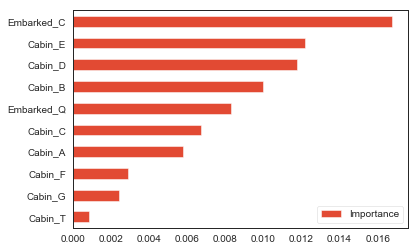

In [50]:
RandomForest_model = RandomForestClassifier(n_estimators=100)
RandomForest_model.fit( train_X , train_y )
print ('Performance of Training set',RandomForest_model.score( train_X , train_y )) 
print('Performance of validation set',RandomForest_model.score( valid_X , valid_y ))
plot_model_var_imp(RandomForest_model, train_X, train_y)

### 2. Gradient Boosting Classifier

('Performance of Training set', 0.8876404494382022)
('Performance of validation set', 0.8059701492537313)
0.8876404494382022


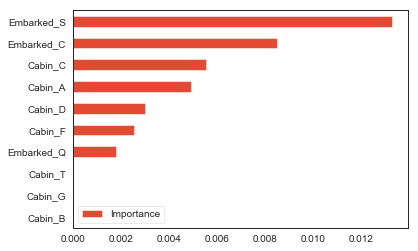

In [51]:
GradientBoost_model = GradientBoostingClassifier()
GradientBoost_model.fit( train_X , train_y )
print ('Performance of Training set',GradientBoost_model.score( train_X , train_y )) 
print('Performance of validation set',GradientBoost_model.score( valid_X , valid_y ))
plot_model_var_imp(GradientBoost_model, train_X, train_y)

### 3. Decision Tree Classifier

('Performance of Training set', 0.7800963081861958)
('Performance of validation set', 0.7985074626865671)
0.9823434991974318


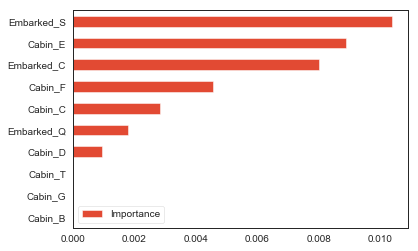

In [52]:
tree = DecisionTreeClassifier( random_state = 99 )
tree.fit( train_X , train_y )
print ('Performance of Training set',model.score( train_X , train_y )) 
print('Performance of validation set',model.score( valid_X , valid_y ))
plot_model_var_imp( tree , train_X , train_y)

### 4. Support vector machine

In [53]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit( train_X , train_y )
print ('Performance of Training set',SVM_model.score( train_X , train_y )) 
print('Performance of validation set',SVM_model.score( valid_X , valid_y ))

('Performance of Training set', 0.8298555377207063)
('Performance of validation set', 0.7014925373134329)


### 5. K nearest Neighbors Classifier

In [54]:
KNN_model = KNeighborsClassifier(n_neighbors = 3)
KNN_model.fit( train_X , train_y )
print ('Performance of Training set',KNN_model.score( train_X , train_y )) 
print('Performance of validation set',KNN_model.score( valid_X , valid_y ))

('Performance of Training set', 0.8250401284109149)
('Performance of validation set', 0.7126865671641791)


### 6. Gaussian Naive Bayes

In [55]:
NB_model = GaussianNB()
NB_model.fit( train_X , train_y )
print ('Performance of Training set',NB_model.score( train_X , train_y )) 
print('Performance of validation set',NB_model.score( valid_X , valid_y ))

('Performance of Training set', 0.7351524879614767)
('Performance of validation set', 0.7425373134328358)


### 7. Logistic Regression

In [56]:
LR_model = LogisticRegression()
LR_model.fit( train_X , train_y )
print ('Performance of Training set',LR_model.score( train_X , train_y )) 
print('Performance of validation set',LR_model.score( valid_X , valid_y ))

('Performance of Training set', 0.7800963081861958)
('Performance of validation set', 0.7985074626865671)


# Sprint 3

### Model Performance

In [57]:
# Score the model
print (RandomForest_model.score( train_X , train_y ) , RandomForest_model.score( valid_X , valid_y ))

(0.9823434991974318, 0.7947761194029851)


### selecting the optimal number of features and visualizing

In [60]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR

rfecv = RFECV(estimator = RandomForest_model, step = 1 , cv = StratifiedKFold(2) , scoring = 'accuracy' )
rfecv.fit( train_X , train_y )

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
   verbose=0)

(0.9807383627608347, 0.8059701492537313)
Optimal number of features : 3


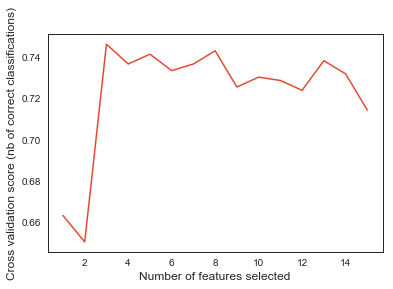

In [61]:
print (rfecv.score( train_X , train_y ) , rfecv.score( valid_X , valid_y ))
print( "Optimal number of features : %d" % rfecv.n_features_ )

#Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel( "Number of features selected" )
plt.ylabel( "Cross validation score (nb of correct classifications)" )
plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
plt.show()

In [71]:
test_Y = RandomForest_model.predict( test_X )
passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'titanic_pred.csv' , index = False )

In [63]:
Prediction = pd.DataFrame(pd.read_csv("titanic_pred.csv"))

In [68]:
len(Prediction[Prediction.Survived==1])

158

In [69]:
len(Prediction[Prediction.Survived==0])

260